In [39]:
### New version created to adapt from 230530_CACloudKT_v2.ipynb ###
### after SDSS-V Collaboration Meeting. Intentions: switch from ###
### Vergely+2022 map to Edenhofer+2023, clean up data handling  ###
### process, "freeze" derived DIB amplitudes, run much of the   ###
### cloud at once                                               ###

from multiprocessing import Pool
import os
os.environ['OMP_NUM_THREADS'] = "1"

import numpy as np

import astropy.units as u  
import astropy.constants as c
from astropy.coordinates import SkyCoord

import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
import matplotlib 

from astropy.io import fits
from astropy.table import Table, join
from scipy.interpolate import interp1d

from dustmaps.bayestar import BayestarQuery
from dustmaps.vergely2022 import Vergely2022Query
from dustmaps.edenhofer2023 import Edenhofer2023Query

import pickle 
import sys
import os
import tqdm

import emcee
import corner

In [40]:
### Load in CA Cloud Summary Data 
CA_meta = Table(fits.open('../Data/230420_CAResiduals/CA_meta.fits')[1].data)
CAresdir = '/uufs/astro.utah.edu/common/home/u1371365/Data/230420_CAResiduals/'
CAMADGICSresdir = '/uufs/astro.utah.edu/common/home/u1371365/Data/230829_MADGICSResiduals/'
starhorsepath = '/uufs/chpc.utah.edu/common/home/sdss/dr17/env/APOGEE_STARHORSE/APOGEE_DR17_EDR3_STARHORSE_v2.fits'
starhorse = Table.read(starhorsepath, hdu = 1)
starhorse = starhorse['APOGEE_ID', 'dist16', 'dist50', 'dist84', 'AV16', 'AV50', 'AV84']

CA_meta = join(CA_meta, starhorse, keys = 'APOGEE_ID', join_type = 'left')

In [41]:
distance = np.linspace(0, 800, 800)


l0, b0 = (163., -8.0)
l_ = np.linspace(l0 - 9., l0 + 9., 800)
b_ = np.linspace(b0 - 9., b0 + 9., 800)
l, b, d = np.meshgrid(l_, b_, distance)
print(l.shape)

coords = SkyCoord(l*u.deg, b*u.deg,
                  distance=distance*u.pc, frame='galactic')
edenhoferquery = Edenhofer2023Query()
# edenhofer = edenhoferquery(coords) * 2.658 # https://zenodo.org/record/7811871

(800, 800, 800)


Optimizing map for querying (this might take a couple of seconds)...


In [42]:
distance_vergely = np.linspace(0, 1000, 200)


l0, b0 = (163., -8.0)
l_vergely_ = np.linspace(l0 - 9., l0 + 9., 200)
b_vergely_ = np.linspace(b0 - 9., b0 + 9., 200)
l_vergely, b_vergely, d_vergely = np.meshgrid(l_vergely_, b_vergely_, distance_vergely)
print(l_vergely.shape)

coords_vergely = SkyCoord(l_vergely*u.deg, b_vergely*u.deg,
                  distance=distance_vergely*u.pc, frame='galactic')

vergelyquery = Vergely2022Query()
vergely = vergelyquery(coords_vergely)

(200, 200, 200)


In [43]:
import h5py
with h5py.File('edenhofer_out.h5', 'r') as f:
    edenhofer = np.array(f['data'])
    

In [44]:
# with h5py.File('edenhofer_out.h5', 'w') as f:
#     f.create_dataset('data', edenhofer.shape, data = edenhofer, dtype = np.float16)

In [45]:
# fig, ax = plt.subplots(figsize = (6,6))
# im = ax.imshow(np.nansum(edenhofer , axis = 2), origin = 'lower', cmap = 'binary', extent = (l0-9, l0+9, b0-9, b0+9))
# ax.set_xlabel('l (deg)')
# ax.set_ylabel('b (deg)')
# # ax.scatter(CA_meta['GLON'], CA_meta['GLAT'])
# fig.colorbar(im)
# plt.show()

In [46]:
lambda0 = 15272.42 
sigma0 = 1.15

def get_wavs(hdulist = None, rv = 0):
    if hdulist is None:
        CRVAL1 = 4.179
        CDELT1 = 6e-06
        LEN = 8575
    else:
        header = hdulist[1].header
        CRVAL1 = header['CRVAL1']
        CDELT1 = header['CDELT1']
        LEN = header['NAXIS1']
        
    wavs = np.power(10, CRVAL1 + CDELT1 * np.arange(LEN))
    wavs = wavs * (1 + rv / 3e5) # allows for shifting to observed frame from rest frame
    return wavs

wavs = get_wavs()
window = (wavs > lambda0 -10) & (wavs < lambda0 + 10)
window_inds = np.where(window)[0]
wavs_window = wavs[window]
window_mask = (wavs_window < lambda0) - 5 | (wavs_window > lambda0 + 5)

def resample_interp(data, rv, resample_wavelengths = wavs, hdu_sel = None):
    wavs_rv = get_wavs(rv = rv, hdulist = hdu_sel)
    interp = interp1d(wavs_rv, data, kind = 'slinear', bounds_error = False)
    
    data_interp = interp(resample_wavelengths)
    
    return data_interp

def dopplershift(v, lambda0 = lambda0):
     return (lambda0 * u.Angstrom * (c.c + v * u.km / u.s) / c.c).to(u.Angstrom).value

In [47]:
def get_ca_res(fname):
    return str(CAresdir + str(fname))

def get_madgics_res(fname):
    return str(CAMADGICSresdir) + str(fname)

def select_stars(tab, l0, b0, radius = 1):
    cond = np.sqrt((tab['GLON'] - l0)**2 + (tab['GLAT'] - b0)**2) < radius
    return np.where(cond)[0]

In [48]:
mhdul = fits.open(get_madgics_res(CA_meta['FILE'][0]))
mwavs = get_wavs(hdulist = mhdul) #same from [125:]
mwindow = (mwavs > lambda0 - 9) & (mwavs < lambda0 + 9)
mwavs_window = mwavs[mwindow]

5
6
6
3
2
8
7
6


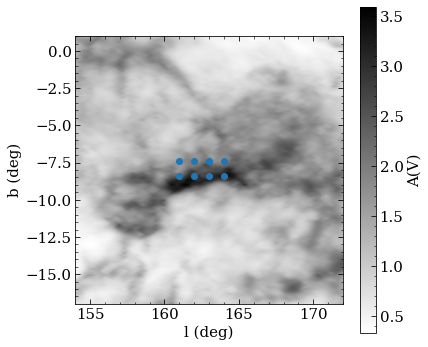

In [49]:
l_cen = 164 
b_cen = -7.4

grid_l, grid_b = np.meshgrid(np.linspace(-3, 0, 4), np.linspace(-1, 0, 2))
grid_l = grid_l.ravel() + l_cen
grid_b = grid_b.ravel() + b_cen

selected_inds = []
for i in range(len(grid_l)):
    l_center, b_center = grid_l[i], grid_b[i]
    selection = select_stars(CA_meta, l_center, b_center, radius = .23)
    print(len(selection))
    selected_inds.append(selection)


fig, ax = plt.subplots(figsize = (6,6))
im = ax.imshow(np.nansum(edenhofer, axis = 2), origin = 'lower', cmap = 'binary', extent = (l0-9, l0+9, b0-9, b0+9))
ax.set_xlabel('l (deg)')
ax.set_ylabel('b (deg)')
# ax.scatter(CA_meta['GLON'], CA_meta['GLAT'])
ax.scatter(grid_l, grid_b)
fig.colorbar(im, label = "A(V)")
plt.show()

In [50]:
def find_nearest(ll, bb, l_sel = l_, b_sel = b_):

    return np.argmin(np.abs(l_sel - ll)), np.argmin(np.abs(b_sel - bb))

def find_nearest_dist(d):
    return np.argmin(np.abs(distance[:, np.newaxis] - d), axis = 0)


def dAV_dd(l0, b0, bin_edges):
    l_ind, b_ind = find_nearest(l0, b0)
    sightline = np.copy(edenhofer[b_ind, l_ind, :]) #needs to be b then l then :

    d_min, d_max = bin_edges

    extinction = sightline[(distance > d_min) & (distance < d_max)]
    return np.sum(extinction )

def dAV_dd_star(l0, b0, bin_edges, distances):
    l_ind, b_ind = find_nearest(l0, b0)
    d_min, d_max = bin_edges
    sightline = np.copy(edenhofer[b_ind, l_ind, :])
    sightline[(distance < d_min) | (distance > d_max)] = 0
    sightline_av = (np.cumsum(sightline)) 
    d_ind = find_nearest_dist(distances)

    return np.nanmedian(sightline_av[d_ind])

def Differential_Amplitude(dAv_dd, dd = 1):
    if type(dd) == int:
        return  0.024 * dAv_dd * dd  # 1/(np.sqrt(2 * np.pi) * sigma0) * 102e-3 * dAv_dd * dd
    elif dd.shape == dAv_dd.shape:
        return 0.024 * dAv_dd * dd 
    else:
        return 0.024 * dAv_dd * dd[np.newaxis, :]

        #  return 0.024 * dAv_dd * dd[:, np.newaxis]

def dAV_dd_array(l, b, bins, star_dist, dmap_dist = distance):
    l_ind, b_ind = find_nearest(l, b)
    verg_sightline = np.copy(edenhofer[b_ind, l_ind, :]) 
    dAVdd = np.zeros(len(bins)-1)
    dAVdd_all = np.zeros(len(bins)-1)
    dAVdd_mask = np.zeros(len(bins-1))
    for i in range(len(dAVdd)):
        bin_min, bin_max = bins[i], bins[i+1]
        if bin_min < star_dist:
            dist_max = bin_max
            if bin_max >= star_dist:
                dist_max = star_dist
        else:
            dist_max = -np.inf

            
        dAVdd[i] = np.sum(verg_sightline[(dmap_dist > bin_min) & (dmap_dist <= dist_max)])

        dAVdd_all[i] = np.sum(verg_sightline[(dmap_dist > bin_min) & (dmap_dist <= bin_max)])

    dAVdd_mask = (dAVdd == 0).astype(bool)
    return dAVdd, dAVdd_all, dAVdd_mask

In [51]:
def find_nearest_v (ll, bb, l_sel = l_vergely_, b_sel = b_vergely_):

    return np.argmin(np.abs(l_sel - ll)), np.argmin(np.abs(b_sel - bb))

def find_nearest_dist_v (d):
    return np.argmin(np.abs(distance_vergely[:, np.newaxis] - d), axis = 0)

def dAV_dd_array_v(l, b, bins, star_dist, dmap_dist = distance_vergely):
    l_ind, b_ind = find_nearest_v(l, b)
    verg_sightline = np.copy(vergely[b_ind, l_ind, :]) 
    dAVdd = np.zeros(len(bins)-1)
    dAVdd_all = np.zeros(len(bins)-1)
    dAVdd_mask = np.zeros(len(bins-1))
    for i in range(len(dAVdd)):
        bin_min, bin_max = bins[i], bins[i+1]
        if bin_min < star_dist:
            dist_max = bin_max
            if bin_max >= star_dist:
                dist_max = star_dist
        else:
            dist_max = -np.inf

            
        dAVdd[i] = np.sum(verg_sightline[(dmap_dist > bin_min) & (dmap_dist <= dist_max)])

        dAVdd_all[i] = np.sum(verg_sightline[(dmap_dist > bin_min) & (dmap_dist <= bin_max)])

    dAVdd_mask = (dAVdd == 0).astype(bool)
    return dAVdd, dAVdd_all, dAVdd_mask

In [52]:
class sightline:
    ### Container object for stars, sightline dAV_dd, velocity, and spaxel assignment.
    def __init__(self, stars, bins = None, **kwargs):
        self.stars = stars
        dist = self.stars['DIST']

        if bins is not None:
            h = np.histogram(dist, bins)[0]
            self.bins = np.insert(bins[1:][h != 0], 0, bins[0])
            self.bin_inds = np.digitize(dist, bins)
        else:
            self.make_bins()
            self.bin_inds = np.digitize(dist, self.bins)  
        self.rvelo = np.zeros(len(self.bins) - 1)
        self.get_DIBs(**kwargs)
        self.init_signals = self.model_signals(self.rvelo, self.dAVdd)
        self.ndim = len(self.voxel_dAVdd)
        self.nsig = len(self.stars)
        
    def make_bins(self, binsep = 10, dmin = 0):
        ### Assigns stars to distance bins if bins are not already supplied.
        dist = self.stars['DIST']
        bins = np.sort(np.insert(np.delete(dist, np.where(dist <= dmin)[0]), 0, dmin))

        i = 0
        while i >= 0:
            next_bin = np.min(bins[bins > bins[i]])
            bins[i+1] = np.max([next_bin, bins[i] + binsep]) + 0.01
            if bins[i+1] >= np.max(dist):
                bins = bins[:i+2]
                i = -np.inf
            i = i+1
        
        self.bins = bins
            
    def get_DIBs(self, MADGICS = False):
        signals = np.zeros((len(self.stars), len(wavs_window)))
        signal_errs = np.zeros((len(self.stars), len(wavs_window)))
        dAVdd = np.zeros((len(self.stars), len(self.bins)-1))
        dAVdd_all = np.zeros((len(self.stars), len(self.bins)-1))
        dAVdd_mask =np.zeros((len(self.stars), len(self.bins)-1)).astype(bool)
        dAVdd_v = np.zeros((len(self.stars), len(self.bins)-1))
        # print(len(dAVdd_all))
        if MADGICS:
            signals_aspcap = np.zeros((len(self.stars), len(wavs_window)))
            signal_errs_aspcap = np.zeros((len(self.stars), len(wavs_window)))


        # dAVdd = np.zeros(len(self.bins))

        for i in range(len(self.stars)):
            star = self.stars[i]
            res_hdul = fits.open(get_ca_res(star['FILE']))
            signals[i, :] = res_hdul[1].data[window]
            signal_errs[i, :] = res_hdul[2].data[window]
            l, b = star['GLON'], star['GLAT']
            dAVdd[i], dAVdd_all[i], dAVdd_mask[i] = dAV_dd_array(l, b, self.bins, star['DIST'])
            dAVdd_v[i], _, __ = dAV_dd_array_v(l, b, self.bins, star['DIST'])


            if MADGICS:
                signals_aspcap[i, :] = np.copy(signals[i, :])
                signal_errs_aspcap[i, :] = np.copy(signal_errs[i, :])
                res_hdul_m = fits.open(get_madgics_res(star['FILE']))
                signals[i, :] = res_hdul_m[1].data[0, 125:][window]
                # signal_errs[i, :] = res_hdul_m[5].data[0, 125:][window]
                # print(res_hdul[2].data.shape)
                # errs = resample_interp(res_hdul[2].data, rv = - star['VHELIO_AVG'])
                # # if 
                # errs = resample_interp(errs, rv = np.median(res_hdul_m[3].data['MADGICS_VBARY']))
                # signal_errs[i, :] = errs[window]



        self.signals = signals
        self.signal_errs = signal_errs
        self.dAVdd = dAVdd
        self.voxel_dAVdd = np.nanmedian(dAVdd_all, axis = 0)
        self.voxel_dAVdd_std = np.nanstd(dAVdd_all, axis = 0, ddof = 1)
        self.dAVdd_mask = dAVdd_mask.astype(bool)
        self.dAVdd_v = dAVdd_v
        if MADGICS:
            self.signals_aspcap = signals_aspcap
            self.signal_errs_aspcap = signal_errs_aspcap
        # print(self.voxel_dAVdd.shape)
        # self.dAVdd = dAV_dd_array(np.median(self.stars['GLON']), np.median(self.stars['GLAT']), 
        #                           self.bins, np.max(self.bins))

    def model_signals(self, rvelo, dAVdd = None):
        if dAVdd is None:
            dAVdd = self.dAVdd
        # print('dAVdd shape: ', dAVdd.shape)
        # dAVdd[self.dAVdd_mask] = 0
        signals = np.zeros((len(self.stars), len(wavs_window)))
        peak_wavelength = dopplershift(rvelo)
        wavs_grid = np.tile(wavs_window, (len(self.bins) - 1, 1))
        voxel_DIB_unscaled = np.exp(-(wavs_grid - peak_wavelength[:, np.newaxis])**2 / (2 * sigma0**2))
        amp = Differential_Amplitude(dAVdd, self.bins[1:]-self.bins[:-1])

        def single_signal(amp, bindex):
            amp[bindex :] = 0 # THIS MIGHT NEED TO BE -1

            voxel_DIB_scaled = -voxel_DIB_unscaled *  amp[:, np.newaxis] 
            summed_DIB = np.sum(voxel_DIB_scaled, axis = 0)
            # continuum = lambda x, m, b : m * (x - lambda0) + b
            # cont = continuum(wavs_window, 0, b)
            return summed_DIB  + 1


        for i in range(len(self.stars)):
            star = self.stars[i]
            dAVdd_star = dAVdd[i, :]
            # amp = Differential_Amplitude(dAVdd_star, self.bins[1:]-self.bins[:-1])
            amp = Differential_Amplitude(dAVdd_star, 1)

            bin_index = self.bin_inds[i]
            # signals[i, :] = single_signal(bin_index)
            signals[i, :] = single_signal(amp, bin_index)
        return signals
    
    def intake_full(self, sampler_full):
        self.sampler_full = sampler_full
  
    def intake(self, sampler):
        self.sampler = sampler



In [53]:
sightlines = []
for indx in selected_inds:
    sightlines.append(sightline(CA_meta[indx], MADGICS = True))

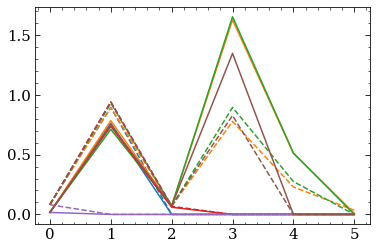

In [54]:
fig, ax = plt.subplots()
for i in range(len(sightlines[1].dAVdd)):
    ax.plot(sightlines[1].dAVdd[i, :], color = 'C'+str(i))
    ax.plot(sightlines[1].dAVdd_v[i, :]* 5, color = 'C'+str(i), linestyle = 'dashed')

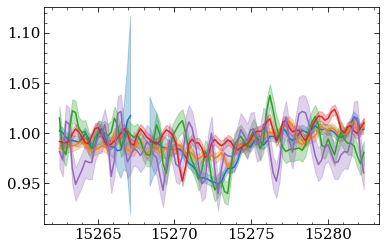

In [55]:
sl0 = sightlines[0]
fig, ax=  plt.subplots()
for i in range(len(sl0.stars)):
    ax.plot(wavs_window, sl0.signals[i, :], color = 'C{}'.format(i))
    ax.fill_between(wavs_window, sl0.signals[i, :] + sl0.signal_errs[i, :], sl0.signals[i, :] - sl0.signal_errs[i, :], color = 'C{}'.format(i), alpha = 0.3)
plt.show()

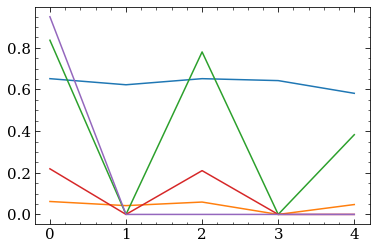

In [56]:
fig, ax = plt.subplots()

ax.plot(sl0.dAVdd)

In [57]:
# model_signals(self, rvelo, dAVdd = None):
sl = sightlines[0]
signals = np.zeros(sl.signals.shape)
signal_errs = np.zeros(sl.signals.shape)
def loglikely_2(v, av, sl = sl, **kwargs):

    # v = p[:int(len(p)/2)]
    # av = p[int(len(p)/2):]
    # av = np.tile(av, len(sl.stars)).reshape(len(sl.stars), -1)

    signal = sl.signals
    sigma = sl.signal_errs

    # print('loglikely av shape' ,av.shape)
    val = - 0.5 * np.nansum((signal - sl.model_signals(v, dAVdd = av))**2 / (sigma**2)) # IS THIS WRONG
    if np.isnan(val):
        # print('fail loglikely')
        return -np.inf
    else:
        return val
    # return - 0.5 * np.sum((signal - sl.model_signals(v, dAVdd = av))**2 / (sigma**2)) 

def logprior_v(v, v_max = 5, prior_mult = 1, **kwargs):
    if (np.any(np.abs(v) > prior_mult * v_max)):
        # print('logprior v -inf')
        return -np.inf
    return 0.0

def logprior_davdd(av, AV_base = 5, AV_max = 10):   
    if (np.any(np.abs(av - AV_base) > AV_max)):
        # print('av -inf')
        return -np.inf
    if ((np.any(av < 0))):
        # print('logprior av -inf')
        return -np.inf
    return 0.0

def logprior_davdd_reg(av,sl, mask = None, **kwargs):
    # print(av.shape)
    # av = np.tile(av, len(sl.stars)).reshape(len(sl.stars), -1) # FOR NOW 
    av = np.copy(av)
    mask = sl.dAVdd_mask
    # mask = av == 0
    av[mask] = np.nan

    # avmed = np.nanmedian(av, axis = 0)
    # avstd = np.nanstd(av, ddof = 1,  axis = 0)
    # avstd[np.isnan(avstd)] = 0.2

    avmed = sl.voxel_dAVdd
    # print(avmed.shape)
    avstd = sl.voxel_dAVdd_std * 15 # should be 10
    # print(avstd.shape)

    # print(av.shape)
    # return 0.0
    # lp_val = np.nansum(np.log(1/(np.sqrt(2 * np.pi) * avstd))) - 0.5 * np.nansum((av - avmed[:, np.newaxis])**2 / (2 * avstd[:, np.newaxis]**2))# first part might not be needed
    # lp_val = np.nansum(- 0.5 * np.nansum((av - avmed[np.newaxis, :])**2 / (2 * avstd[np.newaxis, :]**2)))# first part might not be needed
    lp_val = -np.nansum(np.log(np.sqrt(2 * np.pi))) + np.nansum(- 0.5 * np.nansum((av - avmed)**2 / (2 * avstd**2)))# first part might not be needed

    
    return lp_val
    # return np.sum(np.log(1/(avstd[:, np.newaxis] * np.sqrt(2 * np.pi ))) - 0.5 * (av - avmed[:, np.newaxis])**2 / (2 * avstd[:, np.newaxis]**2)) # first part might not be needed

def logprob_2(p, sl = sl, logprior = logprior_v, loglikely = loglikely_2, **kwargs):
    ndim = len(sl.voxel_dAVdd)
    v = p[ :ndim]
    av = p[ndim:].reshape(-1, ndim)

    # print(av.shape)

    lp = logprior(v, **kwargs)
    lp_davdd = logprior_davdd(av, AV_base = sl.dAVdd)
    lp_davdd_reg = logprior_davdd_reg(av, sl, **kwargs)

    if (not np.isfinite(lp)) | (not np.isfinite(lp_davdd)) | (not np.isfinite(lp_davdd_reg)):
        # print('fail logprob')
        return -np.inf
    return lp + lp_davdd + lp_davdd_reg + loglikely_2(v, av, sl = sl, **kwargs)

def logprob_avfix(p, av = None, sl = sl, logprior = logprior_v, loglikely = loglikely_2, **kwargs):
    ndim = len(sl.voxel_dAVdd)
    v = p[:ndim]

    # av = av.reshape(-1, ndim)

    lp = logprior(v, **kwargs)
    if (not np.isfinite(lp)):
        return -np.inf
    return lp + loglikely_2(v, av, sl = sl, **kwargs)



In [58]:
import time

In [59]:

def MCMC(sl, steps = 1000, nwalkers = 100):
    ndim = len(sl.voxel_dAVdd) 
    ndim_amp = int(2 * ndim)

    sampler = emcee.EnsembleSampler(nwalkers, ndim_amp , logprob_2, 
                                    kwargs={'sl': sl, 'prior_mult':  3, 'v_max': 5, 'sigma': signal_errs})
    init = 7.5 *(np.random.random((nwalkers, ndim_amp)) - 0.5)
  
    init[:, ndim:] = np.abs(sl.voxel_dAVdd[np.newaxis, :] + 0.5*(np.random.random(init[:, ndim:].shape)-0.5))
    print(init.shape)
    sampler.run_mcmc(init,  steps);
    
    return sampler, ndim, ndim_amp


def MCMC_scary(sl, steps = 1000, nwalkers = 100, pool = None):
    ndim = len(sl.voxel_dAVdd) 
    nstar = len(sl.stars)
    ndim_amp = int(ndim + ndim * nstar)
    

    # dAVdd_prior = sl.dAVdd[:]
    # dAVdd_prior[dAVdd_prior == 0] = np.nan 
    # dAVdd_prior_med = np.nanmedian(dAVdd_prior, axis = 1)
    # dAVdd_prior_std = np.nanstd(dAVdd_prior, axis = 1, ddof = 1)
    # gaussparams = (dAVdd_prior_med, dAVdd_prior_std)
    # print(gaussparams)

    # with Pool(15) as pool:

    sampler = emcee.EnsembleSampler(nwalkers, ndim_amp , logprob_2, 
                                    kwargs={'sl': sl,  'prior_mult':  3, 'v_max': 5, 'sigma': signal_errs}, pool = pool)
    init = 12.5 *(np.random.random((nwalkers, ndim_amp)) - 0.5)

    init[:, ndim:] = np.abs(sl.dAVdd.ravel()[np.newaxis, :] + 0.1*(np.random.random(init[:, ndim:].shape)-0.5))
    print('NDIM:', ndim, 'NSTAR:', nstar, 'INITSHAPE:', init.shape)
    
    sampler.run_mcmc(init,  steps, progress = True);
    
    return sampler, ndim, ndim_amp

def MCMC_vonly(sl, sampler_previous, steps = 1000, nwalkers = 100, pool = None):
    ndim = len(sl.voxel_dAVdd) 
    nstar = len(sl.stars)

    samples = sampler_previous.chain[:, 200:, :].reshape((-1, sampler_previous.chain.shape[-1]))
    medians = np.nanmedian(samples[50:, :], axis = 0)
    av = medians[ndim:].reshape(-1, ndim)
    
    # with Pool(15) as pool:

    sampler = emcee.EnsembleSampler(nwalkers , ndim, logprob_avfix, 
                                    kwargs={'sl': sl,  'prior_mult':  3, 'v_max': 5, 'sigma': signal_errs}, pool = pool)
    init = 12.5 *(np.random.random((nwalkers, ndim)) - 0.5)

    # init[:, ndim:] = np.abs(sl.dAVdd.ravel()[np.newaxis, :] + 0.1*(np.random.random(init[:, ndim:].shape)-0.5))
    print('NDIM:', ndim, 'NSTAR:', nstar, 'AVFIXED')
    
    sampler.run_mcmc(init,  steps, progress = True );
    
    return sampler, ndim


In [60]:
stp = 1200
# sampler, ndim, ndim_amp = MCMC_scary(a, steps = stp, nwalkers = 500)
# sampler1, ndim1, ndim_amp1 = MCMC(a1, steps = stp)
# sampler2, ndim2, ndim_amp2 = MCMC(a2, steps = stp)
# sampler3, ndim3, ndim_amp3 = MCMC(a3, steps = stp)

smplr_array = []

if True:
    with Pool(20) as pool:
        for i in range(len(sightlines)):
            start = time.time()
            sl_i = sightlines[i]
            smplr, ndm, ndm_amp = MCMC_scary(sl_i, steps = stp, nwalkers = 500, pool = pool)
            smplr_array.append(smplr)
            mid = time.time()
            # print('Time mid - start', mid - start) # beat 7:22
            # smplr_, ndim_ = MCMC_vonly(sl_i, smplr, steps = 1200, nwalkers = 100, pool = None)
            # end = time.time()
            # print('Time end - start:',(end - start)/60)
            sl_i.intake(smplr)

# sampler, ndim, ndim_amp = smplr, ndm, ndm_amp

NDIM: 5 NSTAR: 5 INITSHAPE: (500, 30)


100%|██████████| 1200/1200 [02:54<00:00,  6.88it/s]


NDIM: 6 NSTAR: 6 INITSHAPE: (500, 42)


100%|██████████| 1200/1200 [02:52<00:00,  6.95it/s]


NDIM: 5 NSTAR: 6 INITSHAPE: (500, 35)


100%|██████████| 1200/1200 [02:53<00:00,  6.93it/s]


NDIM: 3 NSTAR: 3 INITSHAPE: (500, 12)


100%|██████████| 1200/1200 [02:49<00:00,  7.07it/s]


NDIM: 2 NSTAR: 2 INITSHAPE: (500, 6)


100%|██████████| 1200/1200 [02:53<00:00,  6.93it/s]


NDIM: 8 NSTAR: 8 INITSHAPE: (500, 72)


100%|██████████| 1200/1200 [02:56<00:00,  6.82it/s]


NDIM: 7 NSTAR: 7 INITSHAPE: (500, 56)


100%|██████████| 1200/1200 [02:54<00:00,  6.90it/s]


NDIM: 6 NSTAR: 6 INITSHAPE: (500, 42)


100%|██████████| 1200/1200 [02:54<00:00,  6.88it/s]


In [61]:
from multiprocessing import cpu_count

ncpu = cpu_count()
print('{0} CPUs'.format(ncpu))

80 CPUs


In [62]:
sightlines[0].dAVdd.shape

(5, 5)

In [63]:
# smplr_array[0].chain[:, :, 5]

In [64]:
name = '0918b'

if True:
    f = open('sightlines_{}.pickle'.format(name),'wb')
    pickle.dump(sightlines, f )
    f.close()

### sightlines_0821a: first run with this notebook, only difference is change to Edenhofer2023 map
### sightlines_0821b: Uses Edenhofer2023 map. Also freezes A(V) using MCMC_vonly. 1200 steps - 1000 steps
### sightlines_0906b: uses MADGICS DIBs and MADGICS visit-wise uncertainties (didn't work, uncertainties too large)
### sightlines_0908a: same as above; uses MADGICS DIBs and uncertainties from ASPCAP res files. broken.
### sightlines_0908b: ideally same as 0821b. testing to make sure it still works the same. broken.
### sightlines_0911a: ideally same as 0821b. multiprocessed. broken.
### sightlines_0913a: edenhofer map, no freeze. Not great
### sightlines_0914a: edenhofer map, with the dd in amplitude correction set to 1 rather than 5. Does not freeze, don't have infrastructure to freeze
### sightlines_0918a: widened prior on coupled amplitude from 10 to 15
### sightlines_0918b: same as previous but uses MADGICS

if False:
    f = open('sightlines_{}.pickle'.format(name), 'rb')
    sightlines = pickle.load(f)
    f.close()

In [65]:
for i in range(len(sightlines)):
    sightlines[i].intake(smplr_array[i])

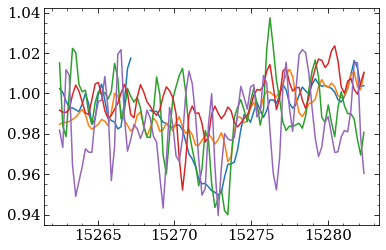

In [66]:
fig, ax = plt.subplots()
sl = sightlines[0]
for i in range(len(sl.signals)):
    ax.plot(wavs_window, sl.signals[i, :], color = 'C{}'.format(i))
    # ax.plot(wavs_window, sl.signals_aspcap[i, :], color = 'C{}'.format(i), linestyle = 'dashed')

plt.show()

In [67]:
# sightlines[0]

In [68]:
def make_corner(sampler, labels, minval = 50):
    dim = sampler.chain.shape[-1]
    samples = sampler.chain[:, minval:, :].reshape((-1, dim))
    # print(samples)
    fig = corner.corner(samples, figsize = (20, 20), labels = labels)
    # for ax in fig.axes:
        # ax.set_xlim(-15, 15)
        # ax.set_ylim(-15, 15) 
    plt.show()

if False:
    for sl in sightlines:
        make_corner(sl.sampler, labels = None)
        break

In [69]:
sampler = smplr_array[0]
ndim = len(sightlines[0].stars)
samples = sampler.chain[:, 50:, :].reshape((-1, sampler.chain.shape[-1]))

medians = np.nanmedian(samples[50:, :], axis = 0)

# med_dAV_dd = np.nanmedian(samples[50:, :], axis = 0)

# print(medians)
med_velo = medians[:ndim]

med_dAV_dd = medians[ndim:].reshape(-1, ndim)

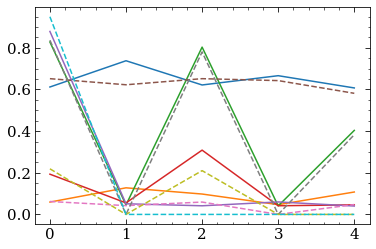

In [70]:
plt.plot(med_dAV_dd)
plt.plot(sightlines[0].dAVdd, linestyle = 'dashed')

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


(5, 95) (5, 5, 95) (5, 5)


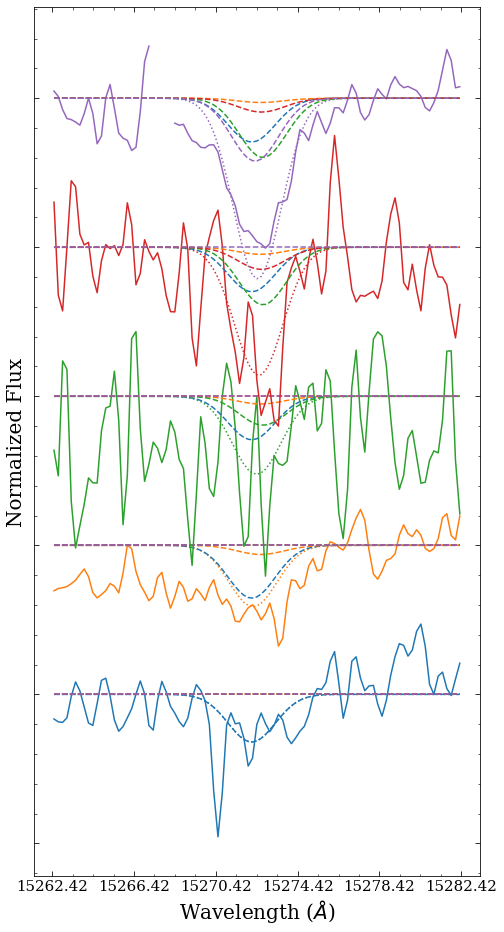

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


(6, 95) (6, 6, 95) (6, 6)


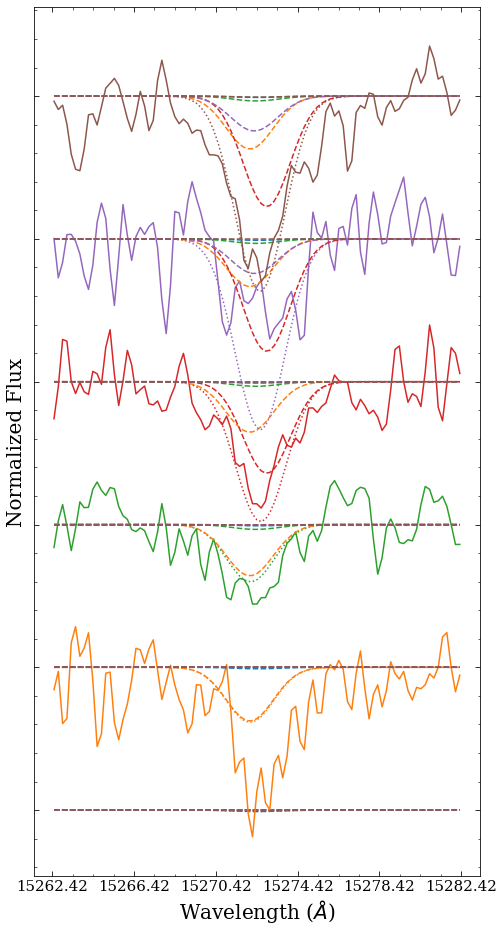

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


(6, 95) (6, 5, 95) (6, 5)


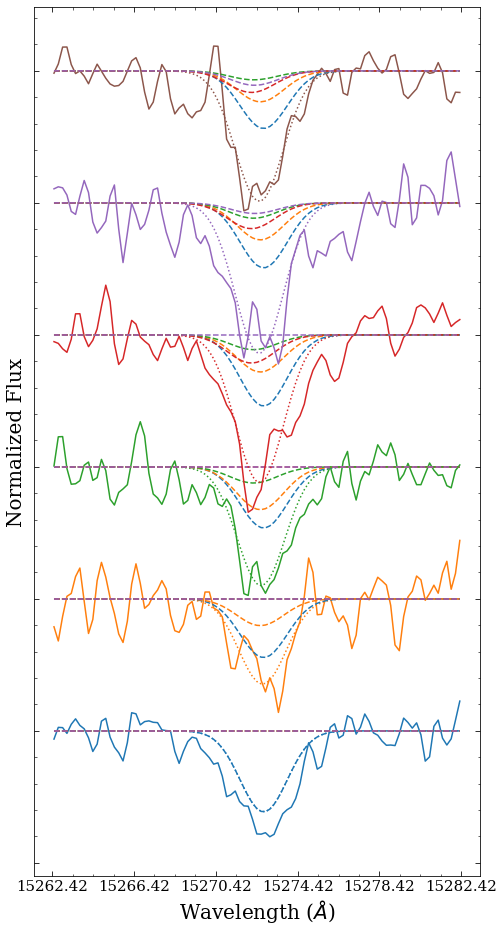

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


(3, 95) (3, 3, 95) (3, 3)


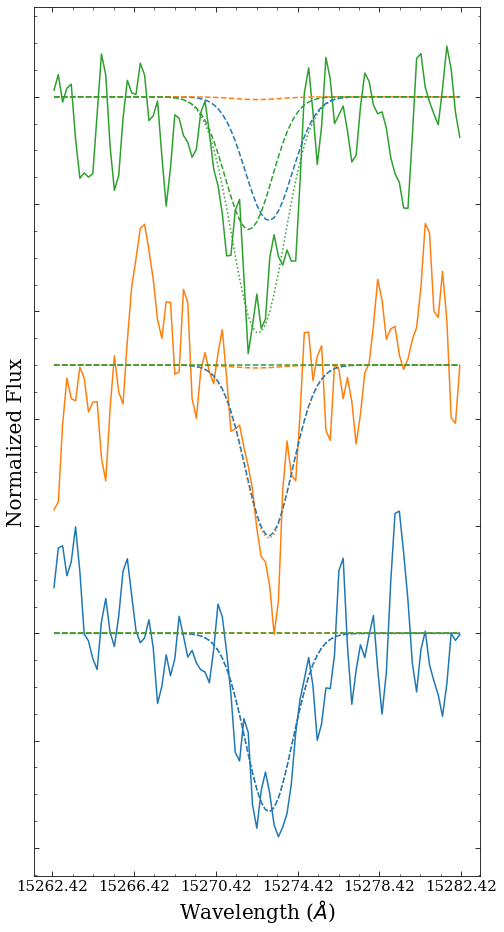

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


(2, 95) (2, 2, 95) (2, 2)


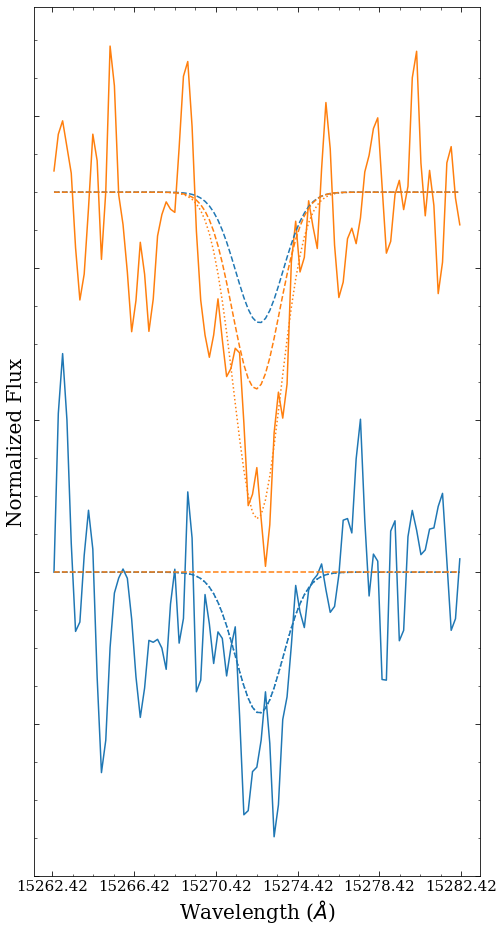

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


(8, 95) (8, 8, 95) (8, 8)


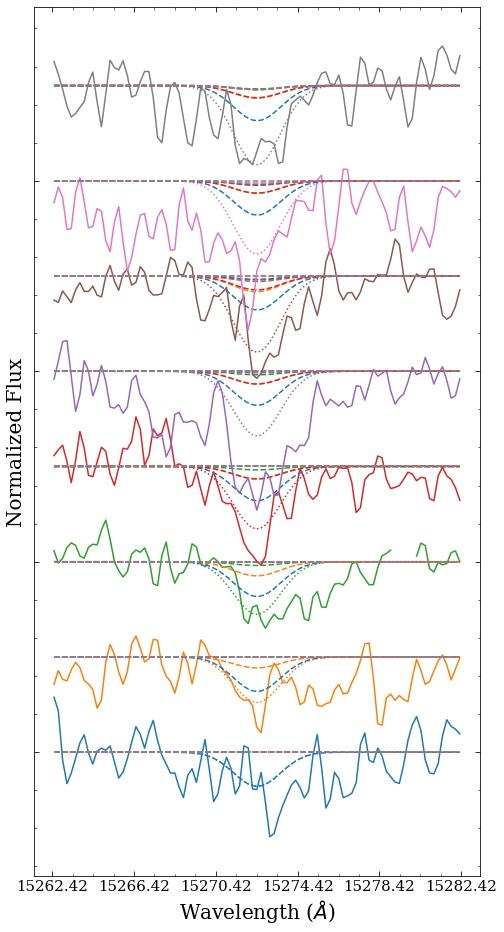

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


(7, 95) (7, 7, 95) (7, 7)


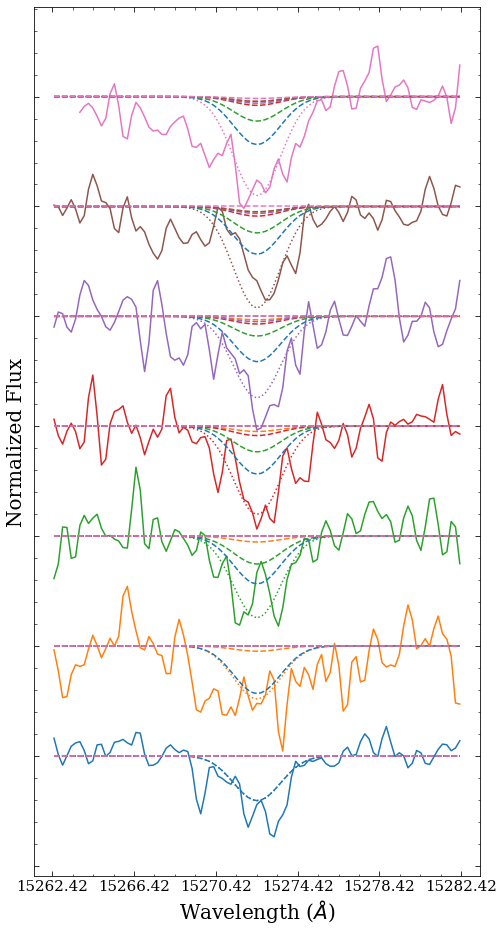

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


(6, 95) (6, 6, 95) (6, 6)


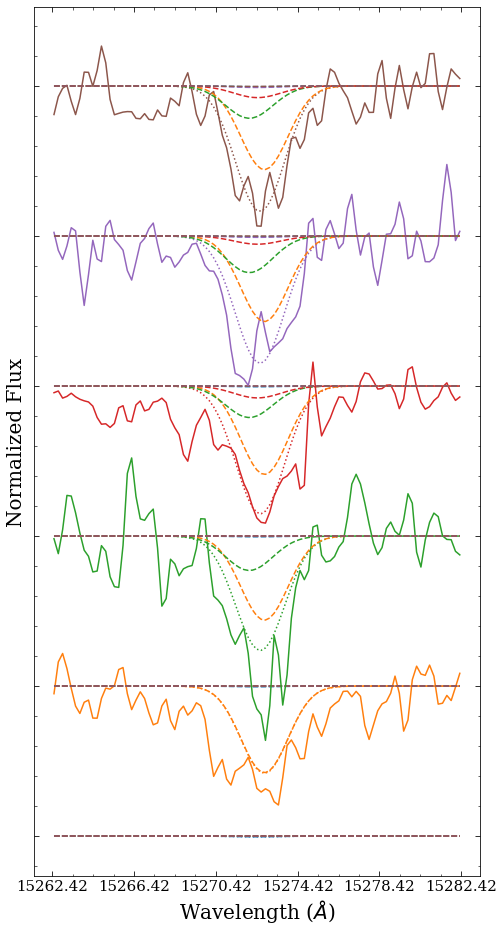

In [71]:
def model_signals_thing(rvelo, sl, dAVdd):
    # dAVdd = sl.dAVdd
    signals = np.zeros((len(sl.stars), len(wavs_window)))
    unsummed_signals = np.zeros((len(sl.stars), len(sl.bins)-1,len(wavs_window)))
    print(signals.shape, unsummed_signals.shape, sl.dAVdd.shape)
    peak_wavelength = dopplershift(rvelo)
    wavs_grid = np.tile(wavs_window, (len(sl.bins) - 1, 1))
    voxel_DIB_unscaled = np.exp(-(wavs_grid - peak_wavelength[:, np.newaxis])**2 / (2 * sigma0**2))
    amp = Differential_Amplitude(dAVdd, sl.bins[1:]-sl.bins[:-1])

    def single_signal(amp, bindex):
        amp[bindex:] = 0 # THIS MIGHT NEED TO BE -1
        # print(amp)

        voxel_DIB_scaled = -voxel_DIB_unscaled *  amp[:, np.newaxis] 
        summed_DIB = np.sum(voxel_DIB_scaled, axis = 0)
        # continuum = lambda x, m, b : m * (x - lambda0) + b
        # cont = continuum(wavs_window, 0, b)
        return summed_DIB  + 1, voxel_DIB_scaled 


    for i in range(len(sl.stars)):
        star = sl.stars[i]
        dAVdd_star = dAVdd[i, :]
        # amp = Differential_Amplitude(dAVdd_star, self.bins[1:]-self.bins[:-1])
        amp = Differential_Amplitude(dAVdd_star, 1)

        bin_index = sl.bin_inds[i]
        # signals[i, :] = single_signal(bin_index)
        signals[i, :], unsummed_signals[i, :, :] = single_signal(amp, bin_index)

    return signals, unsummed_signals

def plot_DIBS_thing(sampler, sl = sl, plot_objs = None):
    if plot_objs == None:
        fig, ax = plt.subplots(figsize = (8, 16))
    else:
        fig, ax = plot_objs
    # ax.plot(wavs_window, dstack1, label = '300-480 pc')
    # ax.plot(wavs_window, dstack2, label = '480-800 pc')
    ndim = len(sl.voxel_dAVdd)
    nstars = len(sl.stars)

    samples = sampler.chain[:, 50:, :].reshape((-1, sampler.chain.shape[-1]))

    medians = np.nanmedian(samples[50:, :], axis = 0)

    # med_dAV_dd = np.nanmedian(samples[50:, :], axis = 0)

    # print(medians)
    med_velo = medians[:ndim]

    med_dAV_dd = medians[ndim:].reshape(-1, ndim)
    # med_dAV_dd = np.tile(med_dAV_dd, len(sl.stars)).reshape(len(sl.stars), -1)

    order_inds = np.array(np.argsort(sl.stars['DIST']))
    # print(order_inds)

    signal_recreated, signal_recreated_unsummed = model_signals_thing(med_velo, sl, med_dAV_dd) 
    # print('sru shape ', signal_recreated_unsummed.shape)
    # for i in range(len(sl.voxel_dAVdd)):
    for i in range(len(order_inds)):
        ii = order_inds[i]
        # signal_recreated_here = sl.model_signals(med_velo[i], dAVdd = med_dAV_dd[i, :])
        ax.plot(wavs_window, sl.signals[ii, :] + 0.05 * i, color = 'C{}'.format(i))
        ax.plot(wavs_window, signal_recreated[ii, :] + 0.05 * i , color = 'C{}'.format(i), linestyle = 'dotted',)# label = 'recreated signal')

        for j in range(len(sl.bins)-1):
            ax.plot(wavs_window, signal_recreated_unsummed[ii, j, : ] + 1 + 0.05 * i, color='C{}'.format(j), linestyle = 'dashed', alpha = 1)

    ax.legend(loc = 'lower left', fontsize = 20)

    ax.set_xlabel('Wavelength ($\AA$)', fontsize = 20)
    ax.set_ylabel('Normalized Flux', fontsize = 20)
    fig.set_facecolor('white')

    ax.set_xticks(np.arange(lambda0-10, lambda0 + 12, 4))
    ax.set_yticklabels('')

def plot_DIBS_freeze(sampler, sl = sl, plot_objs = None):
    if plot_objs == None:
        fig, ax = plt.subplots(figsize = (8, 16))
    else:
        fig, ax = plot_objs
    # ax.plot(wavs_window, dstack1, label = '300-480 pc')
    # ax.plot(wavs_window, dstack2, label = '480-800 pc')
    ndim = len(sl.voxel_dAVdd)
    nstars = len(sl.stars)

    samples = sampler.chain[:, 50:, :].reshape((-1, sampler.chain.shape[-1]))

    medians = np.nanmedian(samples[50:, :], axis = 0)

    # med_dAV_dd = np.nanmedian(samples[50:, :], axis = 0)

    # print(medians)
    med_velo = medians[:ndim]

    med_dAV_dd = medians[ndim:].reshape(-1, ndim)
    # med_dAV_dd = np.tile(med_dAV_dd, len(sl.stars)).reshape(len(sl.stars), -1)

    order_inds = np.array(np.argsort(sl.stars['DIST']))
    # print(order_inds)

    signal_recreated, signal_recreated_unsummed = model_signals_thing(med_velo, sl, med_dAV_dd) 
    # print('sru shape ', signal_recreated_unsummed.shape)
    # for i in range(len(sl.voxel_dAVdd)):
    for i in range(len(order_inds)):
        ii = order_inds[i]
        # signal_recreated_here = sl.model_signals(med_velo[i], dAVdd = med_dAV_dd[i, :])
        ax.plot(wavs_window, sl.signals[ii, :] + 0.05 * i, color = 'C{}'.format(i))
        ax.plot(wavs_window, signal_recreated[ii, :] + 0.05 * i , color = 'C{}'.format(i), linestyle = 'dotted',)# label = 'recreated signal')

        for j in range(len(sl.bins)-1):
            ax.plot(wavs_window, signal_recreated_unsummed[ii, j, : ] + 1 + 0.05 * i, color='C{}'.format(j), linestyle = 'dashed', alpha = 1)

    ax.legend(loc = 'lower left', fontsize = 20)

    ax.set_xlabel('Wavelength ($\AA$)', fontsize = 20)
    ax.set_ylabel('Normalized Flux', fontsize = 20)
    fig.set_facecolor('white')

    ax.set_xticks(np.arange(lambda0-10, lambda0 + 12, 4))
    ax.set_yticklabels('')

for i in range(len(sightlines)):
    fig, ax = plt.subplots(figsize = (8, 16))

    sl_i = sightlines[i]
    sampler_i = sl_i.sampler
    plot_DIBS_thing(sampler_i, sl = sl_i, plot_objs = (fig, ax))
    plt.show()


In [72]:
def plot_velo(sampler, sl  = sl, min_walker = None, plot_objs = None, color = None):
    if plot_objs == None:
        fig, ax = plt.subplots(figsize = (8,6))
    else:
        fig, ax = plot_objs
    # ax.plot(wavs_window, dstack1, label = '300-480 pc')
    # ax.plot(wavs_window, dstack2, label = '480-800 pc')
    ndim = len(sl.voxel_dAVdd)

    walker_max = sampler.chain.shape[1]

    if min_walker is None:
        min_walker_val = 50
    else:
        min_walker_val = walker_max - min_walker

    samples = sampler.chain[:, min_walker_val:, :].reshape((-1, sampler.chain.shape[-1]))

    avg_av = np.nansum(np.median(sl.dAVdd, axis = 0))
    


    medians = np.nanmedian(samples[min_walker_val:, :], axis = 0)
    stdevs = np.nanstd(samples[min_walker_val:, :], ddof = 1, axis = 0)

    med_velo = medians[:ndim]
    std_velo = stdevs[:ndim]

    med_dAV_dd = medians[ndim:]
    med_dAV_dd = stdevs[ndim:]

    # med_dAV_dd = np.tile(med_dAV_dd, len(sl.stars)).reshape(len(sl.stars), -1)


    # ax.scatter((a.bins[1:] + a.bins[:-1] ) /2 , med_velo)
    # for i in range(len(sl.bins)-1): 
    #     ax.hlines(med_velo[i], sl.bins[i], sl.bins[i+1], linestyle = 'dashed')
    #     if i < len(sl.bins) -2:
    #         ax.vlines(sl.bins[i+1], med_velo[i], med_velo[i+1], linestyle = 'dashed')

    if color == None:
        color_choice = 'k'
    else:
        color_choice = color
    ax.errorbar((sl.bins[1:] + sl.bins[:-1] ) /2 , med_velo, yerr = std_velo, fmt = '.', color = color_choice, capsize = 5)
    ax.scatter((sl.bins[1:] + sl.bins[:-1] ) /2 , med_velo, c = color_choice)
    # ax.errorbar((sl.bins[1:]),med_velo, xerr = (sl.bins[1:] - sl.bins[:-1], np.zeros(med_velo.shape)), yerr = std_velo, fmt = '.' )
    ax.set_xlim(350, 600)
    ax.set_xlabel('Distance (pc)')
    ax.set_ylabel('Radial Velocity (km/s)')

    dist_xx = (sl.bins[1:] + sl.bins[:-1] ) /2
    # med_velo

    return fig, ax, dist_xx, med_velo, std_velo


In [73]:
(sl_i.bins[1:] - sl_i.bins[:-1])

array([115.33801 , 333.0802  ,  74.510315,  35.882507,  13.148193,
        10.01001 ], dtype=float32)

In [74]:
avs = np.zeros(len(sightlines))
for i in range(len(sightlines)):
    sl_i = sightlines[i]
    avs[i] = np.sum(sl_i.voxel_dAVdd)

cnorm = matplotlib.colors.Normalize(np.min(avs), np.max(avs))
cmap = plt.get_cmap('viridis')
mappable = matplotlib.cm.ScalarMappable(norm = cnorm,  cmap = cmap)


(array([-0.02667993, 12.5914265 ]), array([[ 5.50397550e-05, -1.87921718e-02],
       [-1.87921718e-02,  7.47921181e+00]]))


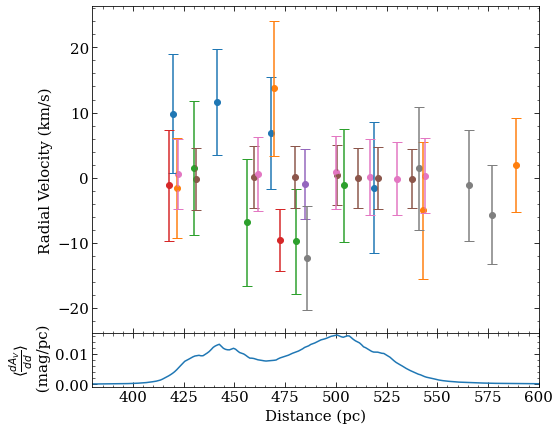

In [75]:
from scipy.optimize import curve_fit
line = lambda x, m, b : m * x + b

sl_davdd = np.zeros((len(grid_l), edenhofer.shape[-1]))
for i in range(len(grid_l)): 
    l_i, b_i = grid_l[i], grid_b[i]
    l_ind, b_ind = find_nearest(l_i, b_i)
    sl_davdd[i, :] = np.copy(edenhofer[b_ind, l_ind, :])


fig, axs = plt.subplots(nrows = 2, ncols = 1, figsize = (8,7), sharex = True, gridspec_kw={'height_ratios': [6,1], 'hspace': 0})


dist_xx = np.array([])
velo_yy = np.array([])
std_velo = np.array([])
for i in range(len(sightlines)):
    sl_i = sightlines[i]
    sampler_i = sl_i.sampler
    color = cmap(cnorm(avs[i]))
    color = 'C'+str(i)
    _, __, dist_xx_i, velo_yy_i, std_velo_i = plot_velo(sampler_i, sl = sl_i, min_walker = 10, plot_objs = (fig, axs[0]), color = color)
    dist_xx = np.concatenate([dist_xx, dist_xx_i])
    velo_yy = np.concatenate([velo_yy, velo_yy_i])
    std_velo = np.concatenate([std_velo, std_velo_i])


dist_sort = np.argsort(dist_xx)[:-8]


fit_result = curve_fit(line, dist_xx[dist_sort], velo_yy[dist_sort], sigma = std_velo[dist_sort])
print(fit_result)
fit_params = fit_result[0]
fit_result_err = np.sqrt(np.diag(fit_result[1]))
xx_plot = np.linspace(380, 600)

# axs[0].plot(xx_plot, line(xx_plot, fit_params[0], fit_params[1]))

# axs[0].fill_between(xx_plot, line(xx_plot, fit_params[0] + fit_result_err[0], fit_params[1] + fit_result_err[1]),
#                     line(xx_plot, fit_params[0] - fit_result_err[0], fit_params[1] - fit_result_err[1]), alpha = 0.1, color = 'C0')

# ymin, ymax = ax.get_ylim()
axs[1].plot(distance, np.nanmedian(sl_davdd, axis = 0) )
# ax.set_ylim(ymin, ymax)
axs[1].set_xlim(380, 600)
axs[1].set_xlabel('Distance (pc)')
axs[1].set_ylabel(r'$ \langle \frac{dA_V}{dd} \rangle $' + '\n (mag/pc)')
fig.set_facecolor('white')
# fig.colorbar(mappable, ax = axs[0], label = 'Sightline A(V) (mag)')

plt.savefig('output_sightlines_{}.png'.format(name), pad_inches = 0.3)
plt.show()